# Pokemon type Classifier

### Importing libraries and read csv

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

from pylab import rcParams
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import scale
from collections import Counter
from scipy.stats import pearsonr


def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues



from sklearn.model_selection import train_test_split


In [19]:

df_original = pd.read_csv('pokemon.csv')
print(df_original.shape)
print(df_original.head())
pokemon_names_original_list = df_original['Name'].tolist()


df = pd.read_csv('Pokemon stats.csv')
df["Name"] = df["Name"].str.lower()
print(df.shape)
print(df.head())


df = df[df.Name.isin(pokemon_names_original_list)] #removing duplicates (mega evolutions?) and pokemon who didn't exist in the original dataset
print(df.shape)
df.head()



(809, 3)
         Name  Type1   Type2
0   bulbasaur  Grass  Poison
1     ivysaur  Grass  Poison
2    venusaur  Grass  Poison
3  charmander   Fire     NaN
4  charmeleon   Fire     NaN
(800, 13)
   #                   Name  Type1   Type2  Total  HP  Attack  Defense  \
0  1              bulbasaur  Grass  Poison    318  45      49       49   
1  2                ivysaur  Grass  Poison    405  60      62       63   
2  3               venusaur  Grass  Poison    525  80      82       83   
3  3  venusaurmega venusaur  Grass  Poison    625  80     100      123   
4  4             charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False  
(698, 13)


,#,Name,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
4,4,charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False


### lets sort the pokemons names in order to keep in match with the available image files

     #        Name    Type1   Type2  Total  HP  Attack  Defense  Sp. Atk  \
0  460   abomasnow    Grass     Ice    494  90      92       75       92   
1   63        abra  Psychic     NaN    310  25      20       15      105   
2  359       absol     Dark     NaN    465  65     130       60       75   
3  617    accelgor      Bug     NaN    495  80      70       40      100   
4  142  aerodactyl     Rock  Flying    515  80     105       65       60   

   Sp. Def  Speed  Generation  Legendary  
0       85     60           4      False  
1       55     90           1      False  
2       60     75           3      False  
3       60    145           5      False  
4       75    130           1      False  
   HP  Attack  Defense  Speed
0  90      92       75     60
1  25      20       15     90
2  65     130       60     75
3  80      70       40    145
4  80     105       65    130
0
               HP    Attack   Defense     Speed
HP       1.000000  0.423352  0.220808  0.159017
Attack 

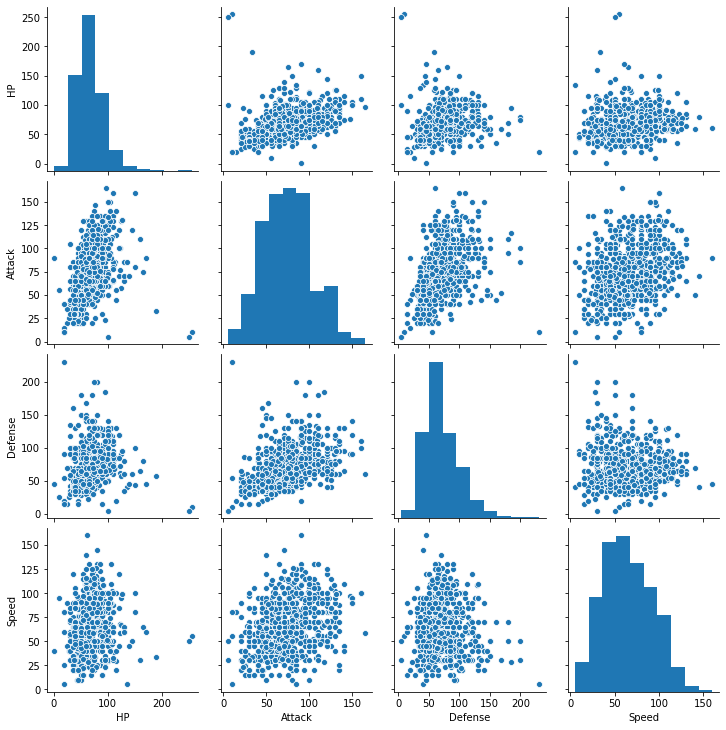

In [20]:
df = df.sort_values(by=['Name'], ascending=True).reset_index(drop=True) #Sorting by name, alphabetically
print(df.head())

df.dtypes # the types of the different columns
hp_attack_defense_speed_df = df[["HP", "Attack", "Defense", "Speed"]] #creating a dataframe which contains only hp, attack, defense and speed since they're all numeric and continous (good for linear regression)
print(hp_attack_defense_speed_df.head())

print(hp_attack_defense_speed_df.isnull().sum().sum())# the result is 0 so there are no missing values here




print(hp_attack_defense_speed_df.corr()) #creating a correlation matrix based on the hp,attack,defense and speed matrix
print(calculate_pvalues(hp_attack_defense_speed_df)) #is p-val calculation working?

sns.pairplot(hp_attack_defense_speed_df) # plotting scatterplots that'll visualize the correlation matrix


#there is a rather strong correlation between hp&attack, attack&defense
reg = linear_model.LinearRegression()
reg.fit(hp_attack_defense_speed_df[["HP", "Defense"]],hp_attack_defense_speed_df.Attack)
print(reg.coef_) # the coefficients are 0.3816505 , 0.36193765 for hp and defense respectively
print(reg.intercept_) #the intercept is 23.14

#predicting attack for an hypothetical pokemon with an hp of 100 and defense of 70:
print(reg.predict([[100,70]])) #the predicted attack is 86.64




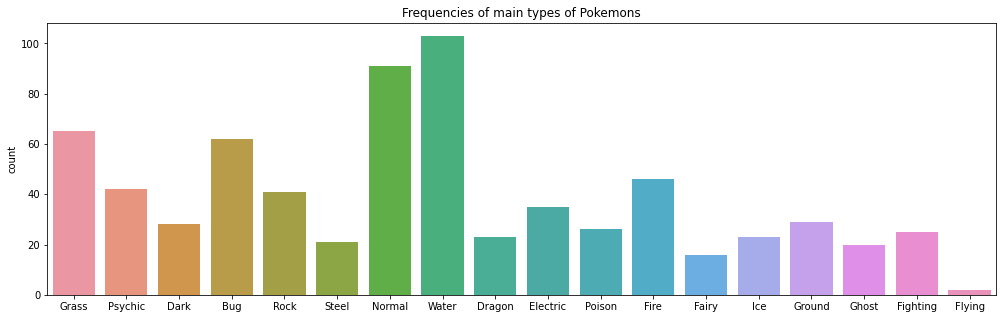

In [21]:
type1 = df['Type1'].tolist()
#type2 = df['Type2'].tolist() - prob delete
#typo = type1 + type2 - prob delete

main_type = type1 #a list with all the main types


plt.figure(figsize=(17, 5))

sns.countplot(x=main_type)
plt.title('Frequencies of main types of Pokemons') 
plt.show() # it seems like water, normal, grass and bug types are the most common main types

In [22]:
main_type_class = df.Type1.value_counts().keys() #the different main classes of pokemons sorted from the most frequent to the least (each class appears once)
main_type_freq = df.Type1.value_counts().values # the corresponding frequency of each class 


#x2 = df.Type2.value_counts().keys() - prob delete
#y2 = df.Type2.value_counts().values - prob delete


In [23]:
main_type_freq_chart = pd.DataFrame({'main_type_class':main_type_class, 'main_type_freq':main_type_freq})
main_type_freq_chart.head(15)
#xy2 = pd.DataFrame({'x2':x2, 'y2': y2}) - prob delete
#xy2.sort_values(by=['x2'],ascending=True, inplace=True) - prob delete

,main_type_class,main_type_freq
0,Water,103
1,Normal,91
2,Grass,65
3,Bug,62
4,Fire,46
5,Psychic,42
6,Rock,41
7,Electric,35
8,Ground,29
9,Dark,28


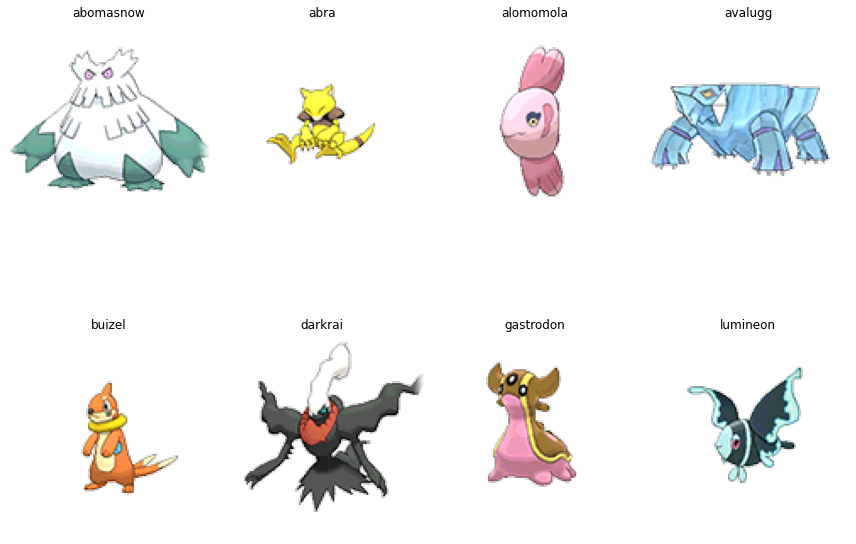

In [24]:
path = 'images/'
fig,((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12, 10))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(8):
    img = mpimg.imread(path+df['Name'][i**3]+'.png')
    ax[i].imshow(img)
    ax[i].set_title(df['Name'][i**3])
    ax[i].axis('off')
plt.tight_layout()
plt.show()
    

### Image Path Dataframe 

In [25]:

img_name = sorted(os.listdir(path)) # list of all the names, sorted alphabetically
img_paths = []
for i in img_name:
       
    if i[:len(i)-4:] in df["Name"].tolist():
        img_paths.append(path + i) # a list with all the paths of the different pokemons (again,alphabetically)
print(len(img_paths))



    


    

698


In [26]:
df['filepath'] = img_paths #adding colomn of path to the spreadsheet (bug - a mismatch between the size of the dataset and the num of images)

In [27]:

poke_type = []
code = []

for i in range(df.shape[0]): #iterate over the number of pokemons, generating a vector of pokemon classes and a vector of codes
    if (df.iloc[i]['Type1']=='Water'):
        poke_type.append('Water')
        code.append(1)
    elif (df.iloc[i]['Type1']=='Normal'):
        poke_type.append('Normal')
        code.append(2)
    elif (df.iloc[i]['Type1']=='Grass'):
        poke_type.append('Grass')
        code.append(3)
    elif (df.iloc[i]['Type1']=='Bug'):
        poke_type.append('Bug')
        code.append(4)
    else:
        poke_type.append(None)
        code.append(None)
df['poke_type'] = poke_type


In [28]:
# adding the pokemon type and code vectors to the main spreadsheet 

print(df.shape)
df = df.dropna()
print(df.shape)




(698, 15)
(156, 15)


In [29]:
df.head()

,#,Name,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,filepath,poke_type
0,460,abomasnow,Grass,Ice,494,90,92,75,92,85,60,4,False,images/abomasnow.png,Grass
12,591,amoonguss,Grass,Poison,464,114,85,70,85,80,30,5,False,images/amoonguss.png,Grass
20,168,ariados,Bug,Poison,390,70,90,70,60,60,40,2,False,images/ariados.png,Bug
30,184,azumarill,Water,Fairy,420,100,50,80,60,80,50,2,False,images/azumarill.png,Water
31,298,azurill,Normal,Fairy,190,50,20,40,20,40,20,3,False,images/azurill.png,Normal


Text(0, 0.5, 'Number of images')

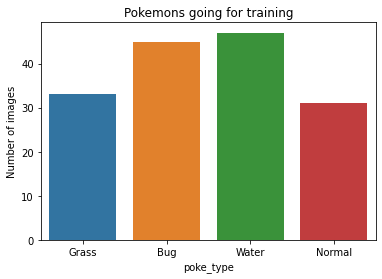

In [30]:
#histogram which shows frequencies of the different pokemon types
sns.countplot(x=df.poke_type)
plt.title('Pokemons going for training')
plt.ylabel('Number of images')

In [57]:
df.columns
df.head()


(156, 15)

In [80]:
from PIL import Image, ImageOps
from numpy import asarray
pokemon_pixel_vals = []
for i in df['filepath']:
        temp_image=Image.open(i)
        temp_array = asarray(ImageOps.grayscale(temp_image))
        flat_temp = np. reshape(temp_array, 14400) #120^2 = 14400
        pokemon_pixel_vals.append(flat_temp)









C:\Users\yoavr\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [88]:
#Logistic regression - multiclass classification


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

train_test_split(pokemon_pixel_vals,df['poke_type'])



data_train, data_test, target_train, target_test = train_test_split(pokemon_pixel_vals,df['poke_type'], test_size = 0.3)

model = LogisticRegression()
model.fit(data_train,target_train)
model.score(data_test,target_test)

# #predicting:
pred_image=Image.open(df['filepath'][65])
pred_image.show()
print(df['poke_type'][65])
model.predict(pokemon_pixel_vals[65])





Grass


ValueError: Expected 2D array, got 1D array instead:
array=[0 0 0 ... 0 0 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.